In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc

from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

data_dir = "/Users/jonathanzhu/Documents/data/"

text_file_name = "osdg-community-data-v2023-01-01.csv"
text_df = pd.read_csv(data_dir + text_file_name,sep = "\t",  quotechar='"')
col_names = text_df.columns.values[0].split('\t')
text_df[col_names] = text_df[text_df.columns.values[0]].apply(lambda x: pd.Series(str(x).split("\t")))
text_df = text_df.astype({'sdg':int, 'labels_negative': int, 'labels_positive':int, 'agreement': float}, copy=True)

font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}

from matplotlib import cm
colors = list(cm.get_cmap('tab20').colors)

file_name = "/Users/jonathanzhu/Documents/bookchapter/source/sdg_names_definitions.csv"
sdg_names = pd.read_csv(file_name)
sdg_names

def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    for labelid in classlabel:
        feature_names = vectorizer.get_feature_names_out()
        top_n = sorted(zip(classifier.feature_log_prob_[labelid], feature_names), reverse=True)[:n]
        for coef, feat in top_n:
            print("SDG {} : {:30}  {:.6}".format(labelid, feat, coef))
        print("")
def print_top_n_features(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        top_n = np.argsort(clf.feature_log_prob_[i])[::-1][:n]
        print("%s: %s" % (class_label,
              " || ".join(feature_names[j] for j in top_n)))
        
def get_text_df(file_name):
    text_df = pd.read_csv(file_name, sep = "\t", quotechar='"')
    col_names = text_df.columns.values[0].split('\t')
    text_df[col_names] = text_df[text_df.columns.values[0]].apply(lambda x: pd.Series(str(x).split("\t")))
    text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
    text_df = text_df.astype({'sdg':int, 'labels_negative': int, 'labels_positive':int, 'agreement': float}, copy=True)
    text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2")
    text_df.reset_index(drop=True, inplace=True)
    return text_df

/var/folders/px/b7vc3nh913zb_m0x36ncftj00000gn/T/ipykernel_73547/3280906689.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = list(cm.get_cmap('tab20').colors)


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

embed = hub.load("/Users/jonathanzhu/Documents/bookchapter/source/universal-sentence-encoder_4")

text_df = get_text_df(data_dir + text_file_name)
text_df["embedding"] = list(embed(text_df.text))

2023-07-18 20:45:18.975424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 20:45:43.233008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


```{index} evaluating classification
```

# Evaluating Classification

In many classification problems, the metrics we use include precision, recall. f1, accuracy, and average accuracy (both macro and micro). Additional common metrics for classification include ROC (Receiver Operating Characteristics) and AUC (Area Under the Curve), often combined as ROC-AUC, and for multi-class classification, we can test the model's ability to classify items on a One vs. Rest (OvR) or One vs. One (OvO) basis. 

In Section 2, we defined precision, recall, and f1. Accuracy is self-explanatory as the proportion of correctly predicted classes as a whole. The micro average accuracy calculates the average accuracy per class, while macro average accuracy similarly calculates this but takes class imbalance into account. 

For this section, we're going to focus on the results from our ridge classification in the previous section. Notice that we get the specific results for each goal on its own, in addition to a confusion matrix for the specific results on the testing set.


              precision    recall  f1-score   support

           1     0.7340    0.7401    0.7371       481
           2     0.7529    0.8291    0.7892       316
           3     0.9084    0.9125    0.9104       674
           4     0.8607    0.9525    0.9043       863
           5     0.8723    0.9359    0.9030       920
           6     0.8478    0.8624    0.8550       465
           7     0.8171    0.8753    0.8452       730
           8     0.6942    0.4759    0.5647       353
           9     0.7310    0.6463    0.6861       328
          10     0.7006    0.4297    0.5327       256
          11     0.7747    0.7965    0.7855       462
          12     0.8841    0.5622    0.6873       217
          13     0.7468    0.7923    0.7689       443
          14     0.8849    0.8479    0.8660       263
          15     0.8576    0.8083    0.8322       313
          16     0.9004    0.9499    0.9245      1057

    accuracy                         0.8312      8141
   macro avg     0.8105   

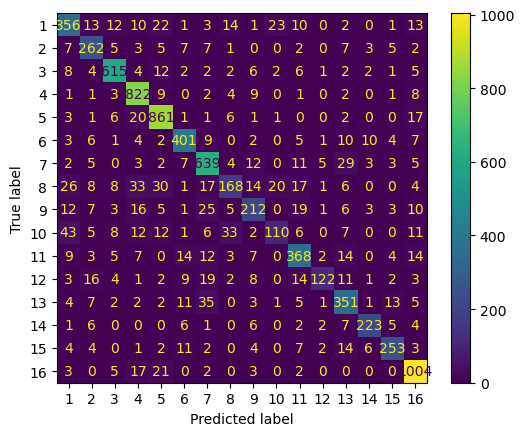

In [3]:
docs = text_df.embedding.tolist()
scaler = preprocessing.MinMaxScaler().fit(docs)
X = scaler.transform(docs)
y = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)
ridge_clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
ridge_clf = ridge_clf.fit(X_train, y_train)
y_pred = ridge_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred, digits = 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

```{index} ROC Curve
```

```{index} true positive rate (TPR)
```

```{index} false positive rate (FPR)
```

```{index} area under the curve (AUC)
```

## 5.1 The ROC Curve

The goal of any classifier is to maximize true positive rate (TPR) while minimizing false positive rate (FPR). The ROC curve is then determined as follows: for any given threshold, we line up the points, with TPR on the Y-axis and FPR on the X-axis. Points at the top left corner of the plot imply an FPR of 0 and a TPR of 1 (i.e., perfect classification). 

A model can be evaluating qualitatively by judging the “steepness” of its ROC curve; this evaluation can be made quantitative by finding the Area Under the Curve (AUC). A larger AUC implies a steeper curve and is <i>usually</i> better.

For binary classification, each point on the ROC curve represents a different threshold and can be a choice for the final classifier to be used; the choice made typically depends on the business requirements and constraints.

```{index} multiclass classification
```

```{index} one vs rest (OvR)
```

## 5.2 Multiclass Classifiers

In any multiclass classification problem, there are multiple class labels $(c_1, c_2, …, c_k)$ in the data, and each training sample is labeled as belonging to one class only. The strategies used with binary classifiers can be taken in multiclass classifiers by reducing the problem to binary classification. There are two strategies typically taken to do this, those being One vs. Rest (OvR) and One vs. One (OvO).

### 5.2.1 One vs Rest
The OvR method of evaluation judges the model ability to determine if a given item belongs to a given class or if it is in one of the other classes. For each class label $c$ in $(c_1, c_2, …, c_k)$, we say that the <i>positive samples</i> are those that are labeled as class $c$, and the <i>negative samples</i> are all the rest of the samples. We then fit and predict for class $c$.

For scoring each sample, we simply take the highest probable score (i.e., highest score) of the $k$ classifiers as the class for the sample. 

When looking at the ROC curve for the OvR strategy on our classification, we get the following graphic:

In [4]:
docs = text_df.embedding.tolist()
scaler = preprocessing.MinMaxScaler().fit(docs)
X = scaler.transform(docs)
y = text_df.sdg

label_binarizer = LabelBinarizer().fit(y)
y_onehot = label_binarizer.transform(y)
n_classes = len(label_binarizer.classes_)
class_names = [sdg_names[sdg_names["sdg"] == label_binarizer.classes_[i]].sdg_name.item() \
               for i in range(n_classes)]

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=.33, random_state=0)
ovr_mlp_clf = OneVsRestClassifier(MLPClassifier(random_state=0, max_iter=300)).fit(X_train,y_train)
y_score = ovr_mlp_clf.predict_proba(X_test)

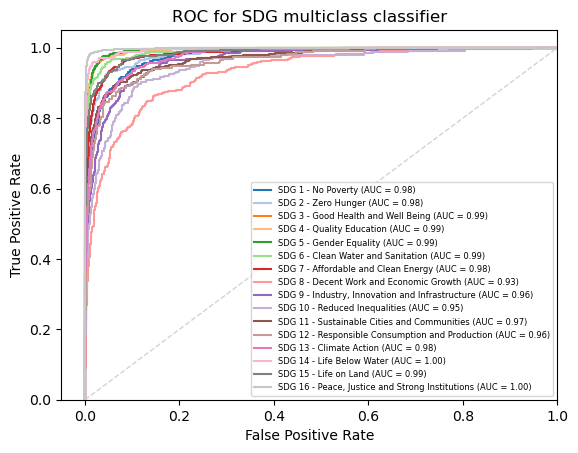

In [5]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_id in range(n_classes):
    fpr[class_id], tpr[class_id], _ = metrics.roc_curve(y_test[:, class_id], y_score[:, class_id]) # roc_curve works on binary
    roc_auc[class_id] = metrics.auc(fpr[class_id], tpr[class_id])

for class_id, color in zip(range(n_classes), colors):
    plt.plot(fpr[class_id], tpr[class_id], color=color, lw=1.5,alpha = 1, 
             label='SDG {0} - {1} (AUC = {2:0.2f})'
             ''.format(class_id+1, class_names[class_id], roc_auc[class_id]))
plt.plot([0, 1], [0, 1], '--', lw=1, color="lightgrey")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for SDG multiclass classifier')
plt.legend(loc="lower right", fontsize=6)
plt.show()

We can see that each of the goals, aside from goal 17, gets its own curve, and our program is able to report the AUC score for each one. 

<b>Exercise 5.1</b>: Create a similar ROC curve plot for your Naive Bayes classification and Multilayer Perceptron classification from the previous section.

```{index} one vs one (OvO)
```

### 5.2.2 One vs One

The OvO approach compares each class to another single class for all possible pairs of classes. For each class label $c$ in $(c_1, c_2, …, c_k)$, and for each pair $(c, c_j)$, with $c_j \neq c$, we say that the <i>positive samples</i> are those that are labeled as class $c$, and the <i>negative samples</i> are those that are labeled as class $c_j$.

For each sample to be scored, it gets $k-1$ classification results, and we then vote by majority to determine the class for the sample. 

Similar to the OvR strategy, we can produce an ROC curve for the OvO strategy as follows:

In [7]:
docs = text_df.embedding.tolist()
scaler = preprocessing.MinMaxScaler().fit(docs)
X = scaler.transform(docs)
y = text_df.sdg

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)

logit_clf = LogisticRegression(tol=1e-2, solver="liblinear")
logit_clf = logit_clf.fit(X_train, y_train)

# metrics.roc_auc_score work on binary and multiclass
y_score = logit_clf.predict_proba(X_test)
print(metrics.roc_auc_score(y_test,y_score, multi_class='ovr'))

0.9830440625522275


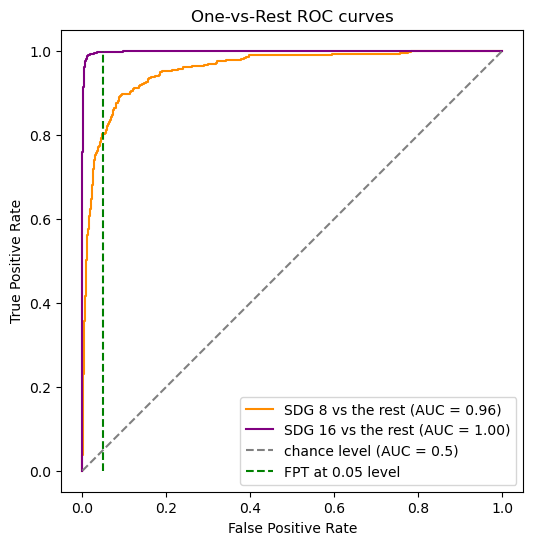

In [8]:
label_binarizer = LabelBinarizer().fit(y)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(figsize=(6,6))

class_of_interest = 8 # SDG 8
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"SDG {class_of_interest} vs the rest",
    color="darkorange",
    ax = ax,
)

class_of_interest = 16
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"SDG {class_of_interest} vs the rest",
    color="purple",
    ax = ax,
)

plt.plot([0, 1], [0, 1], "--", label="chance level (AUC = 0.5)", color = "grey")
plt.plot([0.05, 0.05], [0, 1], "--", label="FPT at 0.05 level", color = "green")

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves")
plt.legend()
plt.show()

Here, we identified two classes that which we wanted to specifically examine, and these two are the only curves that are present on the plot. Note that the AUC for these goals we picked are different from those in the OvR strategy. 

<b>Exercise 5.2</b>: Create another ROC curve plot for three additional goals of your choosing.

<b>Exercise 5.3</b>: Using SDGs 8 and 16, recreate the ROC curve plot using your Naive Bayes and Multilayer Perceptron classifications from the previous sections.

## 5.3 More Exercises

<b>Exercise 5.4</b>: Modify your function from Exercise 3.1 to now output the test set metrics for the classification you run. Be sure to include precision, recall, f1, and accuracy. 

<b>Exercise 5.5</b>: What does a point on the ROC curve at (1,1) indicate about the corresponding model? Similarly, what does a point at (0,0) on the curve indicate about the model?